# Wide & Deep Recommender System 
* reference: https://github.com/yoonkt200/recommender-system/blob/master/deprecated/wide-n-deep/tutorial-keras-classification/classification-keras.py

In [1]:
import argparse

from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Input, Dense, concatenate
from keras.optimizers import Adam

In [2]:
# pre-define about column info
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status",
          "occupation", "relationship", "race", "gender", "capital_gain", "capital_loss", "hours_per_week", "native_country", "income_bracket"]
LABEL_COLUMN = "label"
CATEGORICAL_COLUMNS = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "gender", "native_country"]
NUMERICAL_COLUMNS = ["age", "education_num", "capital_gain", "capital_loss", "hours_per_week"]

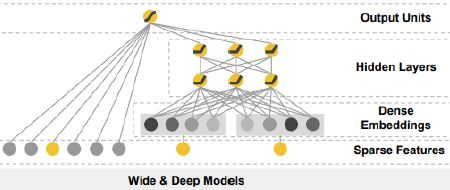

In [4]:
class Wide:
    def __init__(self, args):
        self.learning_rate = args.learning_rate
        self.epochs = args.epochs
        self.batch_size = args.batch_size
        self.input_dim = args.input_dim
        self.model = self.classifier()

    def classifier(self):
        model = Sequential()
        model.add(Dense(1, activation='sigmoid', input_dim=self.input_dim))

        optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999)
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

    def fit(self, x, y):
        self.model.fit(x, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=0.2)

    def print_performance(self, x, y):
        performance_test = self.model.evaluate(x, y, batch_size=self.batch_size)
        print('Test Loss and Accuracy ->', performance_test)

In [3]:
class Deep:
    def __init__(self, args):
        self.learning_rate = args.learning_rate
        self.epochs = args.epochs
        self.batch_size = args.batch_size
        self.input_dim = args.input_dim
        self.model = self.classifier()

    def classifier(self):
        model = Sequential()
        model.add(Dense(100, activation='relu', input_dim=self.input_dim))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999)
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

    def fit(self, x, y):
        self.model.fit(x, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=0.2)

    def print_performance(self, x, y):
        performance_test = self.model.evaluate(x, y, batch_size=self.batch_size)
        print('Test Loss and Accuracy ->', performance_test)

In [5]:
class WideAndDeep:
    def __init__(self, args):
        self.learning_rate = args.learning_rate
        self.epochs = args.epochs
        self.batch_size = args.batch_size
        self.input_dim = args.input_dim
        self.model = self.classifier()

    def classifier(self):
        optimizer = Adam(lr=self.learning_rate, beta_1=0.9, beta_2=0.999)

        # wide part
        wide = Input(shape=(self.input_dim,))

        # deep part
        deep_input = Input(shape=(self.input_dim,))
        deep = Dense(100, activation='relu')(deep_input)
        deep = Dense(50, activation='relu')(deep)

        # concatenate : wide and deep
        wide_n_deep = concatenate([wide, deep])
        wide_n_deep = Dense(1, activation='sigmoid')(wide_n_deep)
        model = Model(inputs=[wide, deep_input], outputs=wide_n_deep)
        model.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
        return model

    def fit(self, wide_x, deep_x, y):
        self.model.fit([wide_x, deep_x], y, epochs=self.epochs, batch_size=self.batch_size, validation_split=0.2)

    def print_performance(self, wide_x, deep_x, y):
        performance_test = self.model.evaluate([wide_x, deep_x], y, batch_size=self.batch_size)
        print('Test Loss and Accuracy ->', performance_test)

In [16]:
def main(model_param):
    # prepare dataset
    df_train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                           header=None,
                           names=COLUMNS,
                           skipinitialspace=True)
    df_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                          header=None,
                          names=COLUMNS,
                          skipinitialspace=True,
                          skiprows=1)
    df = pd.concat([df_train, df_test])
    df[LABEL_COLUMN] = df['income_bracket'].apply(lambda x: ">50K" in x).astype(int)
    y = df[LABEL_COLUMN].values
    df.pop(LABEL_COLUMN)
    df.pop("income_bracket")
    df = pd.get_dummies(df, columns=[x for x in CATEGORICAL_COLUMNS])
    df = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)
    x = df.values

    # split train, test
    train_length = len(df_train)
    x_train = x[:train_length]
    y_train = y[:train_length]
    x_test = x[train_length:]
    y_test = y[train_length:]

    # prepare hyper parameter
    parser = argparse.ArgumentParser()
    parser.add_argument('--batch_size', type=int, default=500,
                        help='Batch size for networks')
    parser.add_argument('--epochs', type=int, default=30,
                        help='Epochs for the networks')
    parser.add_argument('--learning_rate', type=float, default=0.001,
                        help='Learning rate')
    parser.add_argument('--input_dim', type=int, default=x_train.shape[1],
                        help='Input dimension for the generator.')
    args = parser.parse_args('')

    if model_param == "deep":
        deep = Deep(args)
        deep.fit(x_train, y_train)
        deep.print_performance(x_test, y_test)
    elif model_param == 'wide':
        wide = Wide(args)
        wide.fit(x_train, y_train)
        wide.print_performance(x_test, y_test)
    else:
        wide_n_deep = WideAndDeep(args)
        wide_n_deep.fit(x_train, x_train, y_train)
        wide_n_deep.print_performance(x_test, x_test, y_test)

        # prediction for individual
        x_predict_test = x_test[np.newaxis, 0, :]
        y_predict_test = y_test[0]
        result = wide_n_deep.model.predict([x_predict_test, x_predict_test])
        print('result predicted:', result[0][0])
        print('result predicted:', round(result[0][0]))
        print('result real:', y_predict_test)

In [17]:
if __name__ == '__main__':
    main('widendeep')

    # score (test loss and acc)
    # 1. wide : [0.34640224496809097, 0.8394447512213981]
    # 2. deep : [0.3533135050656381, 0.8403660668860226]
    # 3. wide and deep : [0.352460421507851, 0.8432528705885703]

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/30
53/53 [==============================] - 2s 13ms/step - loss: 0.4957 - accuracy: 0.7569 - val_loss: 0.3868 - val_accuracy: 0.8247
Epoch 2/30
53/53 [==============================] - 0s 8ms/step - loss: 0.3631 - accuracy: 0.8316 - val_loss: 0.3509 - val_accuracy: 0.8354
Epoch 3/30
53/53 [==============================] - 0s 8ms/step - loss: 0.3460 - accuracy: 0.8381 - val_loss: 0.3445 - val_accuracy: 0.8396
Epoch 4/30
53/53 [==============================] - 0s 8ms/step - loss: 0.3395 - accuracy: 0.8410 - val_loss: 0.3376 - val_accuracy: 0.8414
Epoch 5/30
53/53 [==============================] - 0s 8ms/step - loss: 0.3335 - accuracy: 0.8436 - val_loss: 0.3337 - val_accuracy: 0.8457
Epoch 6/30
53/53 [==============================] - 0s 8ms/step - loss: 0.3297 - accuracy: 0.8452 - val_loss: 0.3318 - val_accuracy: 0.8462
Epoch 7/30
53/53 [==============================] - 0s 8ms/step - loss: 0.3243 - accuracy: 0.8484 - val_loss: 0.3281 - val_accuracy: 0.8437
Epoch 8/30
53/53 [=